In [1]:
import warnings
warnings.filterwarnings('ignore')

import glob
import numpy as np

from photutils import Background2D, SExtractorBackground
from photutils import DAOStarFinder
from photutils import CircularAperture,aperture_photometry
from photutils.utils import calc_total_error


import astropy.wcs as wcs
from astropy.io import fits
from astropy.stats import sigma_clipped_stats, SigmaClip
from astropy.nddata.utils import Cutout2D
from astropy import units as u

import matplotlib.pyplot as plt
from astropy.visualization import ZScaleInterval

In [2]:
mypath = '/Users/jielaizhang/Desktop/waissya/WAISSYA_LCO/Target_G/B/'
outmoviename='mymovie.gif'

In [3]:
# Load in all of the fits images in the directory and sort it

image_list = glob.glob(mypath+'*e91.fits.fz')
image_list.sort()
print(len(image_list))

30


In [4]:
#Make some useful lists of values to track/record

obstime = []
Bmag = []
Vmag = []
Bmag_e = []
Vmag_e = []
avg_offset = []

In [5]:
# Input the information for the calibration stars identified
# in the previous notebook for batch processing of all of the images

tar_ra    = 314.45162 #314.45139
tar_dec   = -5.685318 #-5.68518
tar_color = 'yellow'
ref_ra    = [314.3665,   314.37668, 314.47,  314.51679]
ref_dec   = [-5.6719439,-5.6451192,-5.8264558,-5.6908192]
ref_colors = ['white','white','white','white']
ref_mag   = [12.775,11.673,12.966,13.032]

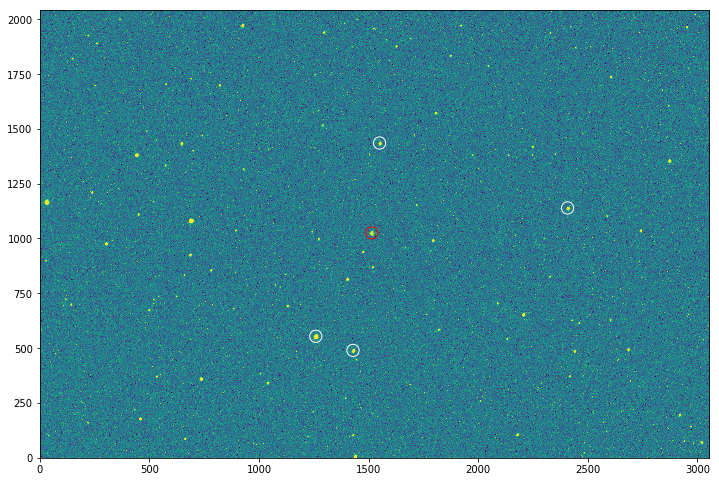

In [6]:
# Plot the whole image and circle the sources for the first exposure

# Grab the actual science data based on above.
hdu = fits.open(image_list[0])
sci_data = hdu[1]
sci_hdr = sci_data.header

w = wcs.WCS(sci_hdr)
xcoord_ref, ycoord_ref = w.all_world2pix(ref_ra,ref_dec,1)
xcoord_target, ycoord_target = w.all_world2pix([tar_ra],[tar_dec],1)

interval = ZScaleInterval()
vmin = interval.get_limits(sci_data.data)[0]
vmax = interval.get_limits(sci_data.data)[1]

figure = plt.figure(figsize=(12,24))
plt.imshow(sci_data.data, vmin=vmin, vmax=vmax, origin='lower')
plt.scatter(xcoord_ref,ycoord_ref,marker='o',facecolors='none',s=150,linewidth=1,color='white')
plt.scatter(xcoord_target,ycoord_target,marker='o',facecolors='none',s=150,linewidth=1,color='red')

In [7]:
def do_phot_get_mag(data,hdr,err,ra,dec):
    positions = []
    zpt_instrumental = 25.
    w = wcs.WCS(hdr)
    xcoords, ycoords = w.all_world2pix(ra,dec,1)
    positions = np.transpose((xcoords, ycoords))
    apertures = CircularAperture(positions, r=24.)
    phot = aperture_photometry(data, apertures, error=err)

    mag = list(-2.5*np.log10(phot['aperture_sum']) + zpt_instrumental)
    dmag = list((2.5/np.log(10))*(phot['aperture_sum_err']/phot['aperture_sum']))
    
    return mag,dmag

In [8]:
def make_cutout(data,hdr,ra,dec):

    w = wcs.WCS(hdr)
    xcoord, ycoord = w.all_world2pix(ra,dec,1)
    position = np.transpose((xcoord, ycoord))
    size = u.Quantity([120, 120], u.pixel)
    cutout = Cutout2D(data, position, size, wcs=w, mode='strict')

    cutout_wcs = cutout.wcs
    header = cutout_wcs.to_header()
    hdu = fits.PrimaryHDU(data=cutout.data, header=header)

    return hdu

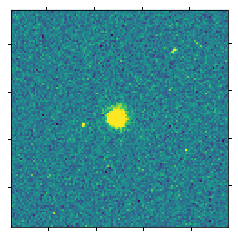

In [9]:
# Let's calculate the star's mag for *each* frame in the dataset

for frame in image_list:
    hdu = fits.open(frame)

    # Grab the actual science data based on above.
    sci_data = hdu[1]
    sci_hdr = sci_data.header
    time = sci_hdr['MJD-OBS']
    obstime.append(time)

    # Background estimation:
    sigma_clip = SigmaClip(sigma=3.) # Sigma clip bright obvious things to avoid biasing the background estimate
    bkg_estimator = SExtractorBackground() # Apply the SExtractor algorithm to our estimation
    bkg = Background2D(
        sci_data.data, (50, 50),
        filter_size=(3, 3),
        sigma_clip=sigma_clip,
        bkg_estimator=bkg_estimator)

    # Now let's subtract the background from the data
    sci_bkg = sci_data.data - bkg.background

    # Define an error image that will be used when calculating photometry
    effective_gain = 1.
    error = calc_total_error(sci_bkg, bkg.background_rms, effective_gain)

    # Calculate instrumental mags for each of the reference stars
    cal_mag,cal_dmag = do_phot_get_mag(sci_bkg,sci_hdr,error,ref_ra,ref_dec)

    # Calculate offsets and the standard deviation of the offset from each star.
    offsets = []
    for i in range(len(cal_mag)):
        offsets.append(ref_mag[i] - cal_mag[i])
    offset = np.mean(offsets)
    avg_offset.append(offset)
    doffset = np.std(offsets)
    
    # Do photometry on the variable target!!
    tar_mag,tar_dmag = do_phot_get_mag(sci_bkg,sci_hdr,error,tar_ra,tar_dec)
    
    cal_tar_mag = tar_mag[0]+offset
    cal_tar_dmag = np.sqrt(tar_dmag[0]**2.+doffset**2.)
    
    Bmag.append(cal_tar_mag)
    Bmag_e.append(cal_tar_dmag)
    
    # Make tiny cutouts of the variable star in each frame
    cutout_hdu = make_cutout(sci_bkg,sci_hdr,tar_ra,tar_dec)
    #cutout_hdu.writeto(frame+'_cutout.fits', overwrite=True)
    
    # Plot figures using these cutouts and output images
    interval = ZScaleInterval()
    vmin = interval.get_limits(cutout_hdu.data)[0]
    vmax = interval.get_limits(cutout_hdu.data)[1]

    plt.subplot(projection=wcs.WCS(cutout_hdu.header))
    plt.imshow(cutout_hdu.data, vmin=vmin, vmax=vmax, origin='lower')
    plt.xlabel('R.A.')
    plt.ylabel('Declination')
    
    pngname = str(time).replace('.','')
    plt.savefig(mypath+pngname+'.png', overwrite=True)
    
Bmag = np.array(Bmag)

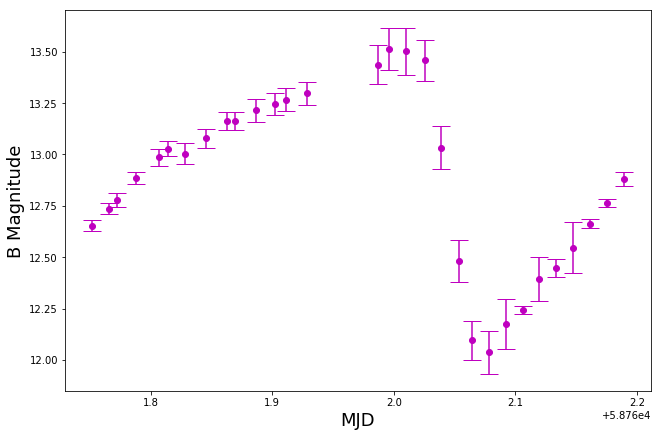

In [10]:
# # Make a rudimentary lightcurve

plt.figure(figsize=(10.5, 7))
plt.errorbar(obstime,Bmag,xerr=None,yerr=Bmag_e, fmt='mo', capsize=9.0)
plt.xlabel('MJD', fontsize=18)
plt.ylabel('B Magnitude', fontsize=18)
plt.show()

In [11]:
# Here we are going to use the cutouts we made above to make
# an little movie of the variable star target changing brightness
# over time and loop it!

import imageio

cutout_list = glob.glob(mypath+'*.png')
cutout_list.sort()

cutout_frames = []
for file in cutout_list:
    cutout_frames.append(imageio.imread(file))
imageio.mimsave(mypath+outmoviename, cutout_frames)

In [12]:
print(list(Bmag))
print(obstime)
print(Bmag_e)

[12.652942869024987, 12.734986155508338, 12.778373669241, 12.887015768232438, 12.985918899692203, 13.027536336676095, 13.078611844628545, 13.16445065002869, 13.162283685197258, 13.214146388834674, 13.24459163052024, 13.267362900096177, 13.297397540146626, 12.174784548970678, 12.241037881867518, 12.448988727313607, 12.663887400185914, 12.765015445279694, 12.87885990771964, 13.436780665362232, 13.51392258268066, 13.501333271941341, 13.457220901761612, 13.033860817363202, 12.481615634381804, 12.096309181640363, 12.038672083201492, 12.393912966164237, 12.546897862145581, 13.003766461769327]
[58761.7515107, 58761.7654433, 58761.7722132, 58761.7882784, 58761.8070682, 58761.8140577, 58761.845337, 58761.8626897, 58761.86961, 58761.8869156, 58761.9025981, 58761.9112109, 58761.9285744, 58762.0918718, 58762.1058281, 58762.1336244, 58762.1613275, 58762.1752368, 58762.1893777, 58761.9870981, 58761.9963839, 58762.0098969, 58762.0258933, 58762.0387717, 58762.0535622, 58762.0639828, 58762.0779156, 587